# 🏦 Proyecto: Modelado de Riesgo de Crédito (Loan Default Prediction)

## 1. Definición del Problema Económico
En el mercado crediticio, las instituciones financieras enfrentan un problema fundamental de **Asimetría de Información**: el banco no conoce con certeza la "calidad" crediticia del prestatario (capacidad y voluntad de pago).

Esto genera dos tipos de riesgos costosos:
1.  **Riesgo de Crédito (Default):** Aprobar un préstamo a un cliente que no pagará. Esto destruye capital (Principal perdido).
2.  **Costo de Oportunidad:** Rechazar a un cliente solvente por clasificarlo erróneamente como riesgoso. Esto reduce los ingresos por intereses.

## 2. Objetivo del Negocio
Desarrollar un modelo de clasificación binaria robusto que automatice la elegibilidad de préstamos.
* **Target (`Risk_Flag`):** `1` (Alto Riesgo / Default) vs `0` (Bajo Riesgo / Pagador).
* **Prioridad:** Maximizar la detección de casos de riesgo (Clase 1) para proteger el capital del banco.

## 3. Descripción de los Datos
El dataset contiene 252,000 observaciones con variables demográficas y financieras (Ingresos, Antigüedad laboral, Propiedad de vivienda, etc.).
* *Nota:* Se trata de un dataset sintético. Aunque las distribuciones de ciertas variables (como `Income`) son uniformes, el dataset es ideal para probar la eficacia de algoritmos de clasificación y técnicas de balanceo de clases ante un target desbalanceado.

## Carga e Inspección Inicial de Datos

In [126]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [127]:
ruta = "https://raw.githubusercontent.com/MrPinkiePie/Loan-Prediction-Portfolio/refs/heads/main/Loan%20Prediction.csv"
data = pd.read_csv(ruta)

In [128]:
data.head(5)

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [129]:
data.drop("Id",axis=1,inplace=True)

In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Income             252000 non-null  int64 
 1   Age                252000 non-null  int64 
 2   Experience         252000 non-null  int64 
 3   Married/Single     252000 non-null  object
 4   House_Ownership    252000 non-null  object
 5   Car_Ownership      252000 non-null  object
 6   Profession         252000 non-null  object
 7   CITY               252000 non-null  object
 8   STATE              252000 non-null  object
 9   CURRENT_JOB_YRS    252000 non-null  int64 
 10  CURRENT_HOUSE_YRS  252000 non-null  int64 
 11  Risk_Flag          252000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 23.1+ MB


In [131]:
data.describe(include="object")

,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE
count,252000,252000,252000,252000,252000,252000
unique,2,3,2,51,317,29
top,single,rented,no,Physician,Vijayanagaram,Uttar_Pradesh
freq,226272,231898,176000,5957,1259,28400


## Análisis Exploratorio de Datos (EDA)

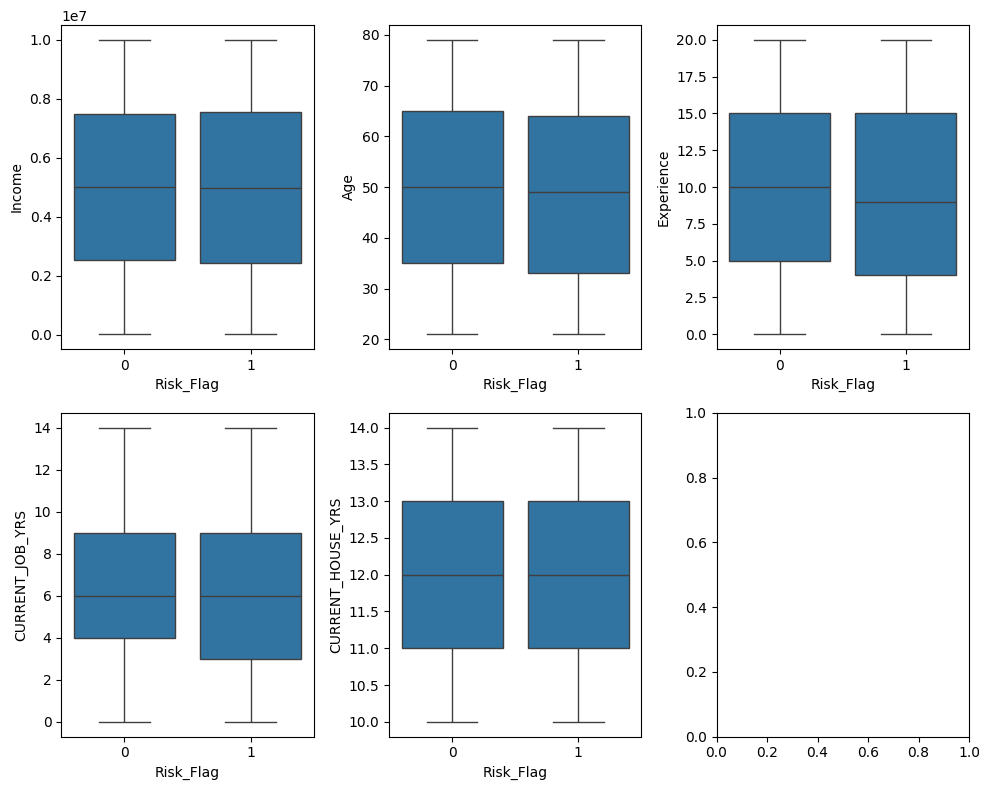

In [132]:
numeric_cols = ['Income', 'Age','Experience',
                'CURRENT_JOB_YRS','CURRENT_HOUSE_YRS']

fig, axs = plt.subplots(2, 3, figsize=(10,8))
axs = axs.flatten()

for idx, col in enumerate(numeric_cols):
    sns.boxplot(data=data, x="Risk_Flag", y=col, ax=axs[idx])

plt.tight_layout()
plt.show()



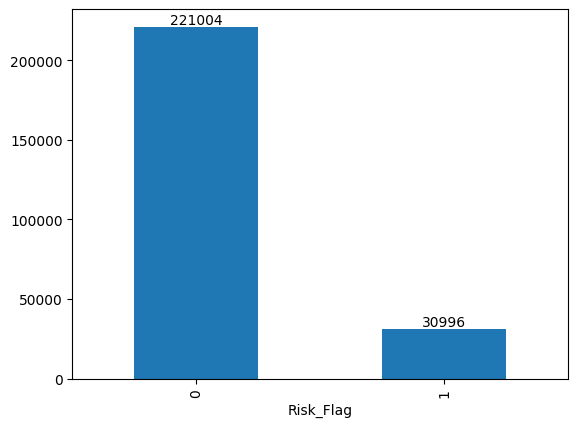

In [133]:
ax = data["Risk_Flag"].value_counts().plot(kind = "bar")
for container in ax.containers:
  plt.bar_label(container)
plt.show()

## Preprocesamiento y Feature Engineering

In [134]:
columnas_utiles = ['Income', 'Age', 'Experience', 'Married/Single', 'House_Ownership',
       'Car_Ownership', 'CURRENT_JOB_YRS',
       'CURRENT_HOUSE_YRS', 'Risk_Flag']

In [135]:
data_clean = data[columnas_utiles]
data_clean.head(5)

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1303834,23,3,single,rented,no,3,13,0
1,7574516,40,10,single,rented,no,9,13,0
2,3991815,66,4,married,rented,no,4,10,0
3,6256451,41,2,single,rented,yes,2,12,1
4,5768871,47,11,single,rented,no,3,14,1


In [136]:
data_clean = pd.get_dummies(data_clean)
data_clean.shape

(252000, 13)

## Split de la data

In [137]:
from sklearn.model_selection import train_test_split

In [138]:
X = data_clean.drop("Risk_Flag",axis = 1)
y = data_clean["Risk_Flag"]

In [139]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## Estrategia 1: Undersampling

In [140]:
from imblearn.under_sampling import RandomUnderSampler

In [141]:
rus = RandomUnderSampler(random_state=42)

In [142]:
X_sub,y_sub = rus.fit_resample(X_train,y_train)

### Modelo XGBoost Undersampled

In [143]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import classification_report, confusion_matrix,auc,roc_auc_score,roc_curve

In [144]:
from sklearn.model_selection import GridSearchCV

In [145]:
param_grid_xgb = {
    # Número de árboles:
    'n_estimators': [200,300],
    # Profundidad máxima del árbol:
    'max_depth': [6,7,9],
    # Tasa de aprendizaje (Learning Rate):
    'learning_rate': [0.15, 0.20,0.25],
    # Subsample:
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0]
}

In [146]:
model_xgb_under = XGBClassifier(random_state = 42)

In [147]:
grid_under = GridSearchCV(estimator = model_xgb_under,
                          param_grid = param_grid_xgb,
                          cv = 5,
                          n_jobs = -1,
                          scoring = "recall",
                          verbose = 2
                          )

In [148]:
grid_under.fit(X_sub,y_sub)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.15, 0.2, 0.25],
                         'max_depth': [6, 7, 9], 'n_estimators': [200, 300],
                         'subsample': [0.8]},
             scoring='recall', verbose=2)

In [149]:
print(f"Los mejores parámetros son: {grid_under.best_params_}")
print(f"El mejor score es: {grid_under.best_score_}")

Los mejores parámetros son: {'colsample_bytree': 0.8, 'learning_rate': 0.25, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}
El mejor score es: 0.8425819510992725


In [150]:
best_xgb_model = grid_under.best_estimator_

In [151]:
y_pred_xgb = best_xgb_model.predict(X_test)

In [152]:
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.97      0.86      0.92     44147
           1       0.47      0.84      0.60      6253

    accuracy                           0.86     50400
   macro avg       0.72      0.85      0.76     50400
weighted avg       0.91      0.86      0.88     50400



In [153]:
y_prob_xgb = best_xgb_model.predict_proba(X_test)[:,1]

In [154]:
fpr,tpr,thresholds = roc_curve(y_test,y_prob_xgb)

In [155]:
auc_score = roc_auc_score(y_test,y_prob_xgb)

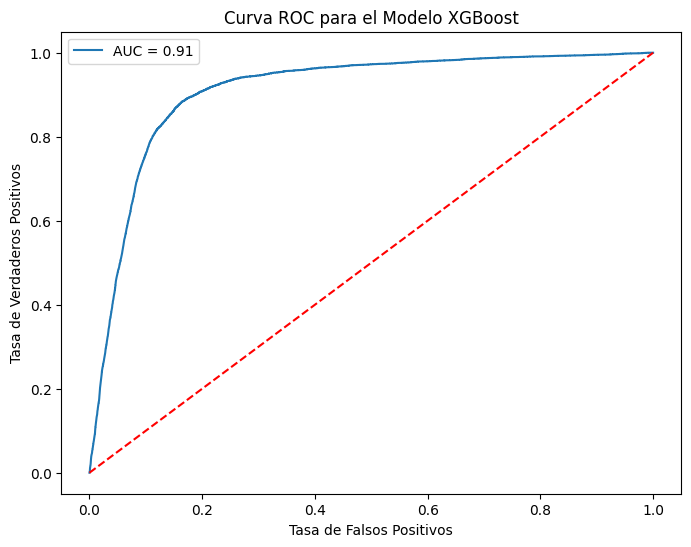

In [156]:
plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0,1],[0,1],color = "red",linestyle = "--")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC para el Modelo XGBoost")
plt.legend()
plt.show()

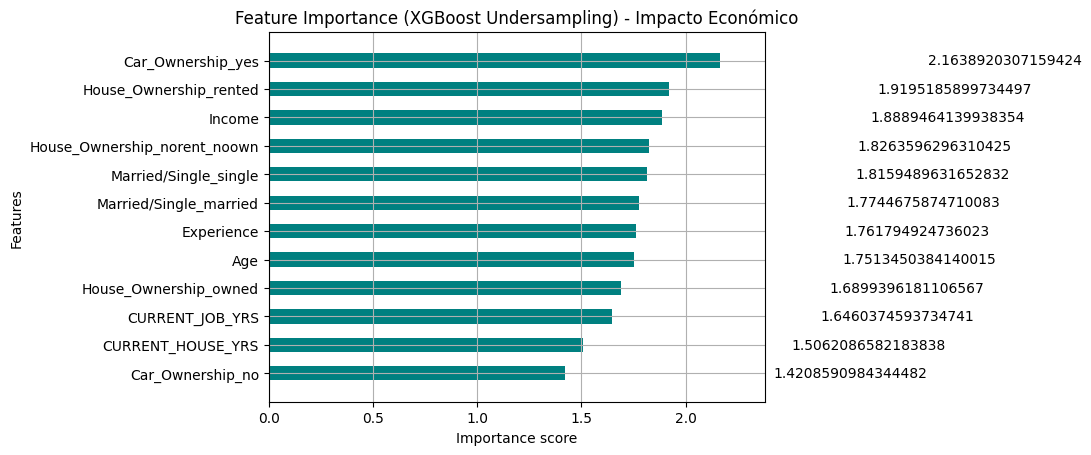

In [157]:
plot_importance(best_xgb_model,importance_type='gain', height=0.5, color='teal')
plt.title('Feature Importance (XGBoost Undersampling) - Impacto Económico')
plt.show()

### Modelo de Regresión Logística Undersampled

In [158]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,auc,roc_auc_score,roc_curve

In [159]:
from sklearn.model_selection import GridSearchCV

In [160]:
X_train_scaled = X_sub.copy()
X_test_scaled = X_test.copy()

In [161]:
cols_to_scale = ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']
scaler = StandardScaler()

In [162]:
scaler.fit(X_train_scaled[cols_to_scale])

StandardScaler()

In [163]:
X_train_scaled[cols_to_scale] = scaler.transform(X_train_scaled[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test_scaled[cols_to_scale])

In [164]:
param_grid_log = {
    'solver': ['saga'],
    # Penalizaciones a probar
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.1, 1, 10],
    'l1_ratio': [0.5]
}

In [165]:
model_log_under = LogisticRegression(random_state = 42,max_iter=2000)

In [166]:
grid_log_under = GridSearchCV(estimator=model_log_under,
                          param_grid = param_grid_log,
                          cv = 5,
                          scoring='recall',
                          n_jobs = -1)

In [167]:
grid_log_under.fit(X_train_scaled,y_sub)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'l1_ratio': [0.5],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['saga']},
             scoring='recall')

In [168]:
print(f"Mejor parámetro: {grid_log_under.best_params_}")
print(f"Mejor score: {grid_log_under.best_score_}")

Mejor parámetro: {'C': 10, 'l1_ratio': 0.5, 'penalty': 'l2', 'solver': 'saga'}
Mejor score: 0.5768497935204241


In [169]:
best_log_model = grid_log_under.best_estimator_

In [170]:
y_pred_log = best_log_model.predict(X_test_scaled)

In [171]:
print(classification_report(y_test,y_pred_log))

              precision    recall  f1-score   support

           0       0.89      0.49      0.63     44147
           1       0.14      0.57      0.22      6253

    accuracy                           0.50     50400
   macro avg       0.51      0.53      0.43     50400
weighted avg       0.80      0.50      0.58     50400



In [172]:
y_prob_log = best_log_model.predict_proba(X_test_scaled)[:,1]

In [173]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_log)

In [174]:
auc_score = roc_auc_score(y_test, y_prob_log)

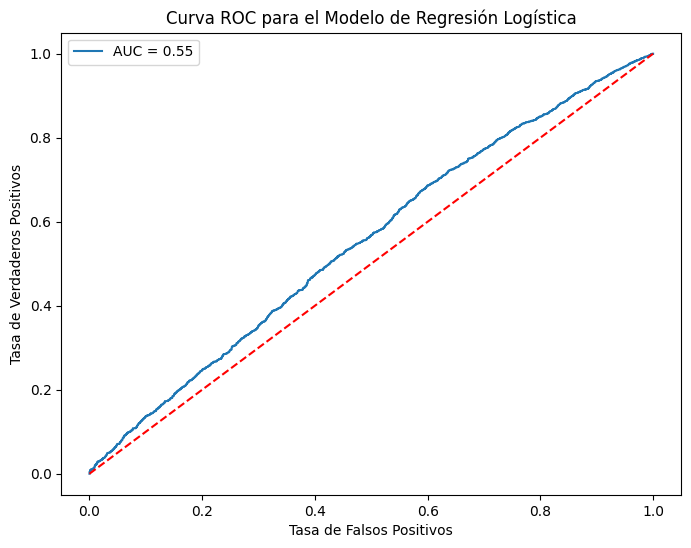

In [175]:
plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0,1],[0,1],color = "red",linestyle = "--")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC para el Modelo de Regresión Logística")
plt.legend()
plt.show()

## Estrategia 2: Oversampling

In [176]:
from imblearn.over_sampling import RandomOverSampler

In [177]:
ros = RandomOverSampler(random_state=42)

In [178]:
X_over, y_over = ros.fit_resample(X_train,y_train)

### Modelo de Regresión Logística Oversampled

In [179]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,auc,roc_auc_score,roc_curve

In [180]:
from sklearn.model_selection import GridSearchCV

In [181]:
X_train_scaled = X_over.copy()
X_test_scaled = X_test.copy()

In [182]:
cols_to_scale = ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']
scaler = StandardScaler()

In [183]:
scaler.fit(X_train_scaled[cols_to_scale])

StandardScaler()

In [184]:
X_train_scaled[cols_to_scale] = scaler.transform(X_train_scaled[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test_scaled[cols_to_scale])

In [185]:
param_grid_log = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],      # Ya sabemos que L2 funciona bien, descartamos L1/ElasticNet para ahorrar tiempo
    'solver': ['liblinear']
}

In [186]:
model_log_over = LogisticRegression(random_state = 42,max_iter=2000)

In [187]:
grid_log_over = GridSearchCV(estimator=model_log_over,
                          param_grid = param_grid_log,
                             cv = 3,
                             scoring='recall',
                             n_jobs = -1
                             )

In [188]:
grid_log_over.fit(X_train_scaled,y_over)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['liblinear']},
             scoring='recall')

In [189]:
print(f"Mejor parámetro: {grid_log_over.best_params_}")
print(f"Mejor score: {grid_log_over.best_score_}")

Mejor parámetro: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor score: 0.5763865571170838


In [190]:
best_log_model = grid_log_over.best_estimator_

In [191]:
y_pred_log = best_log_model.predict(X_test_scaled)

In [192]:
print(classification_report(y_test,y_pred_log))

              precision    recall  f1-score   support

           0       0.89      0.49      0.64     44147
           1       0.14      0.57      0.22      6253

    accuracy                           0.50     50400
   macro avg       0.51      0.53      0.43     50400
weighted avg       0.80      0.50      0.58     50400



In [193]:
y_prob_log = best_log_model.predict_proba(X_test_scaled)[:,1]

In [194]:
fpr, tpr, threshold_log = roc_curve(y_test, y_prob_log)

In [195]:
auc_score = roc_auc_score(y_test, y_prob_log)

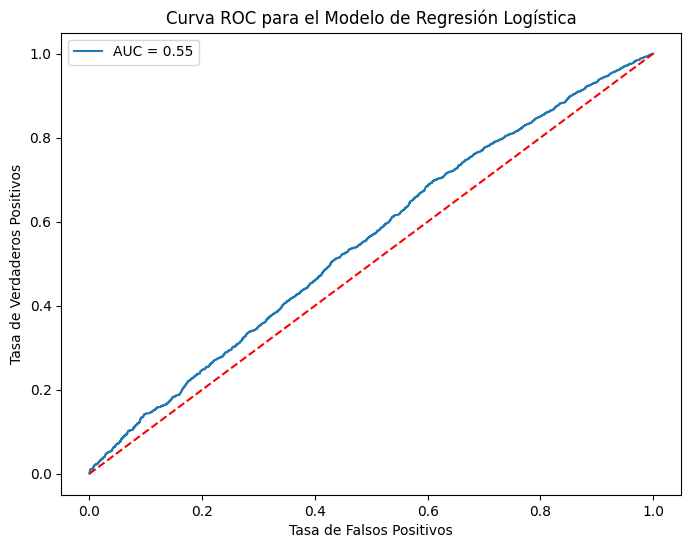

In [196]:
plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0,1],[0,1],color = "red", linestyle = "--")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC para el Modelo de Regresión Logística")
plt.legend()
plt.show()

### Modelo XGBoost Oversampled

In [197]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import classification_report, confusion_matrix,auc,roc_auc_score,roc_curve

In [198]:
from sklearn.model_selection import GridSearchCV

In [199]:
param_grid_xgb = {
    'n_estimators': [200, 300],
    'max_depth': [6, 9],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

In [200]:
model_xgb_over = XGBClassifier(
    tree_method='hist',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

In [201]:
grid_over = GridSearchCV(estimator = model_xgb_over,
                          param_grid = param_grid_xgb,
                         cv = 3,
                         n_jobs = -1,
                         scoring = "recall",
                         verbose = 3
                         )

In [202]:
grid_over.fit(X_over,y_over)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:57:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8], 'learning_rate': [0.1, 0.2],
                         'max_depth': [6, 9], 'n_estimators': [200, 300],
                         'subsample': [0.8]},
             scoring='recall', verbose=3)

In [203]:
print(f"Los mejores parámetros son: {grid_over.best_params_}")
print(f"El mejor score es: {grid_over.best_score_}")

Los mejores parámetros son: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}
El mejor score es: 0.979689804608244


In [204]:
best_xgb_model = grid_over.best_estimator_

In [205]:
y_pred_xgb = best_xgb_model.predict(X_test)

In [206]:
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93     44147
           1       0.51      0.80      0.62      6253

    accuracy                           0.88     50400
   macro avg       0.74      0.85      0.77     50400
weighted avg       0.91      0.88      0.89     50400



#### 🛑 Diagnóstico de Modelo: Detección de Overfitting y Cese de Análisis

**Observación Crítica:**
Al evaluar el modelo XGBoost entrenado con la estrategia de **Oversampling**, detectamos una anomalía severa en el rendimiento:
* **Recall en Entrenamiento (Validación):** ~98% (Extremadamente alto).
* **Recall en Test (Realidad):** 80% (Caída significativa).

**Interpretación:**
Existe una brecha de casi **18 puntos porcentuales**. Esto confirma la presencia de **Overfitting (Sobreajuste)**. El modelo ha "memorizado" los patrones repetitivos generados por el Oversampling en lugar de aprender las características fundamentales del riesgo de crédito.

**Decisión Técnica:**
Comparado con la estrategia de **Undersampling** (que logró un **Recall de 84%** con mayor estabilidad), este modelo es **menos robusto y menos eficaz** para el objetivo del negocio.

> 📉 **Conclusión:** Debido a la falta de capacidad de generalización, **descartamos este modelo** para la fase de producción. Por consiguiente, no procederemos con el análisis de *Feature Importance* ni curvas *ROC-AUC* para esta iteración, centrando nuestros recursos en refinar el modelo ganador (Undersampling).


# Conclusiones Finales y Recomendación de Negocio

## A. Desempeño del Modelo
El proyecto logró construir un modelo predictivo eficaz para mitigar el riesgo de impago (*Default*), superando las limitaciones del desbalance de clases.
* **Modelo Ganador:** XGBoost con estrategia de **Undersampling**.
* **Métrica Clave (Recall):** **84%**. Esto significa que el modelo es capaz de detectar a 84 de cada 100 clientes morosos potenciales, protegiendo significativamente el capital del banco.
* **Robustez:** A diferencia de la estrategia de Oversampling (que mostró un overfitting severo con una caída del 18% entre Train y Test), el modelo de Undersampling demostró una capacidad de generalización sólida en datos no vistos.

## B. Insights Económicos (Determinantes del Riesgo)
El análisis de importancia de variables (`Feature Importance type='gain'`) reveló que el perfil de riesgo no depende únicamente del nivel de ingresos, sino de la estabilidad estructural del cliente:
1.  **Estabilidad Familiar:** El estado civil (*Single*) se posicionó como el predictor número uno. Esto sugiere que los hogares constituidos poseen una mayor resiliencia financiera ante shocks de liquidez.
2.  **Respaldo Patrimonial:** La tenencia de activos (*Car Ownership*) actúa como una señal de solvencia (colateral implícito) superior a la experiencia laboral.
3.  **Ingreso vs. Riesgo:** El *Income* es relevante (Top 3), pero el modelo prioriza la "calidad" del perfil (estabilidad) sobre la "cantidad" de flujo de caja.
